### Step 1: Load the MNIST dataset, load all necessary modules

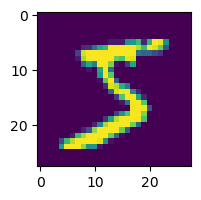

In [1]:
import os, sys
directory_path = os.path.dirname(os.path.abspath("__notebook__"))
sys.path.append('../../')
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from models import rbm
from torchvision import datasets
from sklearn.preprocessing import StandardScaler
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
scaler = StandardScaler()
X = train_dataset.data.numpy()
n_examples = X.shape[0]
X = X.reshape(n_examples, -1)
X = scaler.fit_transform(X)
y = train_dataset.targets.numpy()
plt.figure(figsize=(2, 2))
plt.imshow(scaler.inverse_transform(X[0].reshape(1, -1)).reshape(28, 28))

### Step 2: Train the RBM (no adversary)

In [2]:
model = rbm.RBM(
    n_vis=784,
    n_hid=3000
)
model.fit_autograd(
    X=X[:1000],
    n_gibbs=1,
    lr=0.001,
    n_epochs=100,
    batch_size=50,
    gamma=1,
    rng_seed=0,
    verbose_interval=10,
    checkpoint_path=f'{directory_path}/rbm_checkpoints/rbm_mnist_demo.pth'
)

epoch: 010 of 100 | recon_loss: 0.2879999876022339
epoch: 020 of 100 | recon_loss: 0.24500000476837158
epoch: 030 of 100 | recon_loss: 0.22699999809265137
epoch: 040 of 100 | recon_loss: 0.2160000056028366
epoch: 050 of 100 | recon_loss: 0.2070000022649765
epoch: 060 of 100 | recon_loss: 0.20000000298023224
epoch: 070 of 100 | recon_loss: 0.19599999487400055
epoch: 080 of 100 | recon_loss: 0.1889999955892563
epoch: 090 of 100 | recon_loss: 0.18400000035762787
epoch: 100 of 100 | recon_loss: 0.17900000512599945


### Step 3: Visualize samples

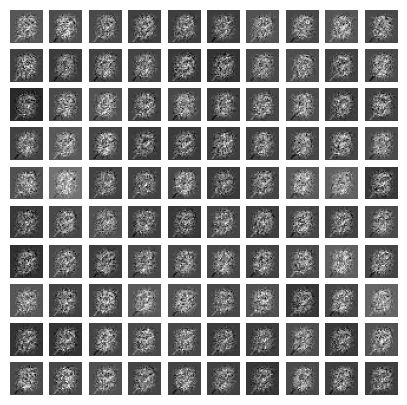

In [3]:
model = rbm.load(f'{directory_path}/rbm_checkpoints/rbm_mnist_demo.pth')
samples = model.reconstruct(np.zeros((100, 784)), n_gibbs=200)
fig, axes = plt.subplots(10, 10, figsize=(5, 5))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(scaler.inverse_transform(samples[i].reshape(1, -1))\
                   .reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()

### Repeat Step 2 for RBM (trained with adversary)

In [6]:
model = rbm.RBM(
    n_vis=784,
    n_hid=100
)
model.fit_autograd(
    X=X[:2000],
    n_gibbs=10,
    lr=0.001,
    n_epochs=100,
    batch_size=30,
    gamma=0.1,
    gamma_delay=50,
    rng_seed=0,
    verbose_interval=10,
    reduce_lr_on_plateau=False,
    checkpoint_path=f'{directory_path}/rbm_checkpoints/rbm_mnist_demo_adv.pth'
)

epoch: 010 of 100 | recon_loss: 0.6790000200271606
epoch: 020 of 100 | recon_loss: 0.6240000128746033
epoch: 030 of 100 | recon_loss: 0.5979999899864197
epoch: 040 of 100 | recon_loss: 0.5830000042915344
epoch: 050 of 100 | recon_loss: 0.5720000267028809
epoch: 060 of 100 | recon_loss: 0.574999988079071
epoch: 070 of 100 | recon_loss: 0.5659999847412109
epoch: 080 of 100 | recon_loss: 0.5649999976158142
epoch: 090 of 100 | recon_loss: 0.5630000233650208
epoch: 100 of 100 | recon_loss: 0.5649999976158142


### Repeat Step 3 for RBM (trained with adversary)

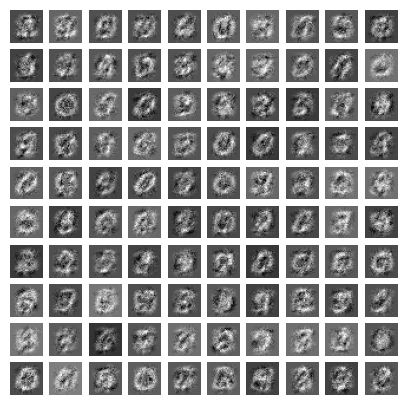

In [3]:
model = rbm.load(f'{directory_path}/rbm_checkpoints/rbm_mnist_demo_adv.pth')
samples = model.reconstruct(np.zeros((100, 784)), n_gibbs=200)
fig, axes = plt.subplots(10, 10, figsize=(5, 5))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(scaler.inverse_transform(samples[i].reshape(1, -1))\
                   .reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()